In [1]:
%load_ext autoreload
%autoreload 2

import torch
from data_process.kitti_dataloader import create_train_dataloader, create_val_dataloader, create_test_dataloader
import json
import tqdm

from models import fpn_resnet

In [2]:
with open("../cfg/cfg.json") as f:
    configs = json.load(f)

In [3]:
configs

{'dataset_dir': '../dataset/kitti/',
 'NX': 1280,
 'NY': 1280,
 'minX': 0,
 'maxX': 50,
 'minY': -25,
 'maxY': 25,
 'minZ': -2.73,
 'maxZ': 1.27,
 'x_range': 64,
 'y_range': 64,
 'z_min': -3,
 'z_max': 6,
 'h_range': 5.5,
 'lidar_height': 1.5,
 'sig_height_range': 2,
 'z_range': 5,
 'dz': 0.05,
 'max_z_gap': 0.5,
 'min_ground_ratio': 0.0005,
 'min_ground_layer_pts': 10,
 'num_classes': 4,
 'max_objects': 200,
 'num_samples': -1,
 'num_workers': 4,
 'pin_memory': True,
 'batch_size': 16,
 'distributed': False}

### 1. Model

Try fpn_resnet_18 for default.

* model:      fpn_resnet
* num_layers: 18
* heads:      configs.heads = {
        'hm_cen': configs.num_classes,
        'cen_offset': configs.num_center_offset,
        'direction': configs.num_direction,
        'z_coor': configs.num_z,
        'dim': configs.num_dim
    }
    
* head_conv:  64

* configs.imagenet_pretrained = True
* configs.head_conv = 64
* configs.num_classes = 3
* configs.num_center_offset = 2
* configs.num_z = 1
* configs.num_dim = 3
* configs.num_direction = 2  # sin, cos


In [16]:
configs['batch_size'] = 1
configs['num_workers'] = 1
heads_cfg = {'hm_cen': 3, 'cen_offset': 2, 'direction': 2, 'z_coor': 1, 'dim': 3}
model = fpn_resnet.get_pose_net(num_layers=18, heads=heads_cfg, head_conv=64, imagenet_pretrained=True)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth


In [5]:
model.eval()

test_dataloader = create_test_dataloader(configs)

with torch.no_grad():
    for batch_idx, batch_data in enumerate(test_dataloader):
        metadatas, bev_maps = batch_data
        print(batch_idx, bev_maps.size())
        outputs = model(bev_maps.float())
        
        for k in outputs:
            print(k, outputs[k].size())
        
        if batch_idx > 2:
            break
        

0 torch.Size([1, 3, 608, 608])
input_h=608, input_w=608
x shape:  torch.Size([1, 3, 608, 608])
after conv1 torch.Size([1, 64, 304, 304])
after bn1 torch.Size([1, 64, 304, 304])
after relu torch.Size([1, 64, 304, 304])
after maxpool torch.Size([1, 64, 152, 152])
out_layer1 shape: torch.Size([1, 64, 152, 152])
out_layer2 shape: torch.Size([1, 128, 76, 76])
out_layer3 shape: torch.Size([1, 256, 38, 38])
out_layer4 shape: torch.Size([1, 512, 19, 19])
up_layer1 shape: torch.Size([1, 512, 38, 38]) ; out_layer3 torch.Size([1, 256, 38, 38])
hm_cen torch.Size([1, 3, 152, 152])
cen_offset torch.Size([1, 2, 152, 152])
direction torch.Size([1, 2, 152, 152])
z_coor torch.Size([1, 1, 152, 152])
dim torch.Size([1, 3, 152, 152])
1 torch.Size([1, 3, 608, 608])
input_h=608, input_w=608
x shape:  torch.Size([1, 3, 608, 608])
after conv1 torch.Size([1, 64, 304, 304])
after bn1 torch.Size([1, 64, 304, 304])
after relu torch.Size([1, 64, 304, 304])
after maxpool torch.Size([1, 64, 152, 152])
out_layer1 shap

In [ ]:
outputs['hm_cen']

### 2. Optimizer and lr_scheduler

In [ ]:
hasattr(model, 'module')

In [ ]:
train_params = [param for param in model.parameters() if param.requires_grad]

In [ ]:
len(train_params)

In [ ]:
# learning rate and weight decay configurable, adam as default
optimizer = torch.optim.Adam(train_params, lr=0.001, weight_decay=0.0)

In [ ]:
lr_scheduler = 

In [17]:
train_dataloader, train_sampler = create_train_dataloader(configs)

metadatas, bev, targets = None, None, None

for batch_idx, batch_data in enumerate(train_dataloader):
    metadatas, bev, targets = batch_data
    
    break


label info: cls_id=1, at (12.81, 5.68, -1.58), h=1.47, w=1.67, l=4.28, yaw=3.05
center_x = 38.94; center_y = 93.26
label info: cls_id=1, at (18.01, 5.55, -1.50), h=1.38, w=1.67, l=4.37, yaw=-3.02
center_x = 54.74; center_y = 92.86
label info: cls_id=1, at (8.23, -5.15, -1.53), h=1.54, w=1.58, l=3.20, yaw=-0.01
center_x = 25.02; center_y = 60.33
label info: cls_id=1, at (5.88, -5.35, -1.55), h=1.51, w=1.72, l=4.03, yaw=-0.01
center_x = 17.87; center_y = 59.75
label info: cls_id=0, at (28.16, 4.97, -1.46), h=1.88, w=0.67, l=1.18, yaw=2.07
center_x = 85.60; center_y = 91.11
label info: cls_id=1, at (8.14, -3.29, -1.62), h=1.77, w=1.63, l=4.10, yaw=-1.57
center_x = 24.75; center_y = 65.99
label info: cls_id=1, at (23.86, -3.36, -1.59), h=1.69, w=1.64, l=4.21, yaw=1.58
center_x = 72.54; center_y = 65.78
label info: cls_id=1, at (29.52, 3.56, -1.64), h=1.55, w=1.64, l=3.70, yaw=-1.58
center_x = 89.74; center_y = 86.83
label info: cls_id=1, at (40.45, 1.38, -1.55), h=1.63, w=1.81, l=4.54, yaw

In [19]:
targets['hm_cen'][0].size()

torch.Size([4, 152, 152])

In [22]:
targets['hm_cen'][0][1][93, 38]

tensor(1.)

In [24]:
import matplotlib.pyplot as plt

In [25]:
mat = targets['hm_cen'][0][1].numpy()

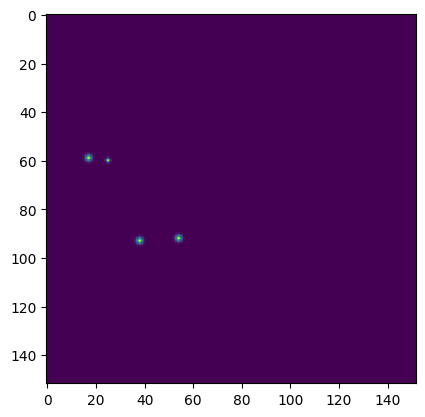

In [26]:
plt.imshow(mat)

In [28]:
mat[91:94, 36:40]

array([[0.00315111, 0.02732372, 0.05613476, 0.02732372],
       [0.02732372, 0.23692776, 0.48675224, 0.23692776],
       [0.05613476, 0.48675224, 1.        , 0.48675224]], dtype=float32)